# Training a VAE on MNIST
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [1]:

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function.

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [0]:
class VAE(nn.Module):

    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1  = nn.Linear(in_features=x_dim, out_features=h_dim1, bias=True)
        self.fc2  = nn.Linear(in_features=h_dim1, out_features=256, bias=True)
        self.fc31 = nn.Linear(in_features=256, out_features=z_dim, bias=True)
        self.fc32 = nn.Linear(in_features=256, out_features=z_dim, bias=True)

        # decoder part
        self.fc4 = nn.Linear(in_features=z_dim, out_features=256, bias=True)
        self.fc5 = nn.Linear(in_features=256, out_features=h_dim1, bias=True)
        self.fc6 = nn.Linear(in_features=h_dim1, out_features=x_dim, bias=True)

    def encoder(self, x): # mu and log_var are computed by the neural network 
                          # (log_var is used for stability and ease of training)
        
        A1 = F.relu(self.fc1(x))
        A2 = F.relu(self.fc2(A1))  
        mu = self.fc31(A2)
        log_var = self.fc32(A2)

        return  mu, log_var
    
    def sampling(self, mu, log_var): # classic sampling is not differentiable, use reparametrization trick

        std = torch.exp(0.5*log_var)  
        z0  = torch.randn_like(std) # torch.randn(std.size()) 
        
        return mu + z0 * std
        
    def decoder(self, z):
        
        A4 = F.relu(self.fc4(z))
        A5 = F.relu(self.fc5(A4))
        A6 = self.fc6(A5)

        return torch.sigmoid(A6)

    def forward(self, x):

        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        image_rec = self.decoder(z)

        return image_rec, mu, log_var

    def get_latent_space(self, x):

      mu, log_var = self.encoder(x)
      z = self.sampling(mu, log_var)

      return  z
      


## Loss function

In [0]:
# build model
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

optimizer = optim.Adam(vae.parameters(), lr=0.02)

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    
    var = log_var.exp()
    RecLoss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLDLoss = -0.5 * torch.sum(log_var - var - mu.pow(2) + 1)
    
    return RecLoss + KLDLoss


## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [0]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda().view(-1, 784)
        optimizer.zero_grad()
        
        recon_x, mu, log_var = vae(data)
        loss = loss_function(recon_x, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        
        if batch_idx % 100 == 0:
            print('  [{:5d}/{} ({:2.0f}%)]\tLoss : {:.6f}'.format(batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Average loss: {:.4f}'.format(train_loss / len(train_loader.dataset)))

## Visualization:
We provide some visualization functions:

In [0]:

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(8, 8), figsize=(8, 8)):
    generatedImages=generatedImages.cpu().numpy()
    print('Generated Images :')
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


## Test
Complete the test function that generate new sample from latent space samples. 

In [0]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda().view(-1, 784)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var)
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss : {:.4f}'.format(test_loss))
    with torch.no_grad():
      z = torch.randn(64, 2).cuda()
      generated = vae.decoder(z)
      sub_generated = generated[:16,:]
      plotGeneratedImages(sub_generated.view(sub_generated.size(0), 1, 28, 28),dim=(2, 8),figsize=(16,4))


## Main loop

TRAIN EPOCH 1 :
  [    0/60000 ( 0%)]	Loss : 545.988516
  [10000/60000 (17%)]	Loss : 175.769863
  [20000/60000 (33%)]	Loss : 159.601504
  [30000/60000 (50%)]	Loss : 168.660430
  [40000/60000 (67%)]	Loss : 166.491797
  [50000/60000 (83%)]	Loss : 166.444687
====> Average loss: 181.3085
====> Test set loss : 161.7077
Generated Images :


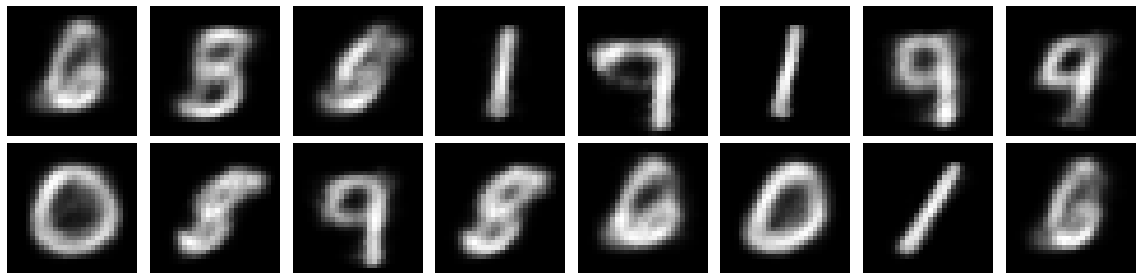

TRAIN EPOCH 2 :
  [    0/60000 ( 0%)]	Loss : 163.139238
  [10000/60000 (17%)]	Loss : 161.699258
  [20000/60000 (33%)]	Loss : 155.242686
  [30000/60000 (50%)]	Loss : 165.389805
  [40000/60000 (67%)]	Loss : 151.372129
  [50000/60000 (83%)]	Loss : 157.674639
====> Average loss: 160.1023
====> Test set loss : 158.2403
Generated Images :


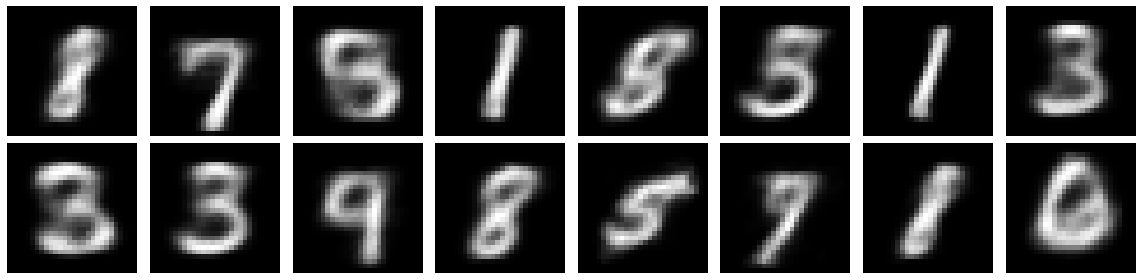

TRAIN EPOCH 3 :
  [    0/60000 ( 0%)]	Loss : 154.279082
  [10000/60000 (17%)]	Loss : 153.421191
  [20000/60000 (33%)]	Loss : 153.494961
  [30000/60000 (50%)]	Loss : 157.842139
  [40000/60000 (67%)]	Loss : 153.440596
  [50000/60000 (83%)]	Loss : 151.833125
====> Average loss: 158.2975
====> Test set loss : 156.7503
Generated Images :


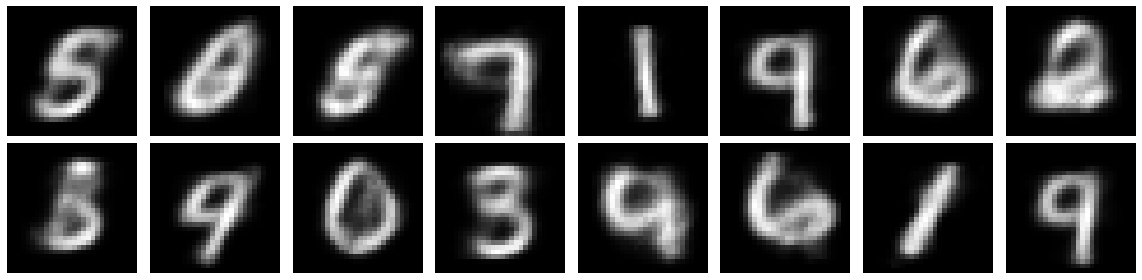

TRAIN EPOCH 4 :
  [    0/60000 ( 0%)]	Loss : 155.745322
  [10000/60000 (17%)]	Loss : 152.601035
  [20000/60000 (33%)]	Loss : 160.894648
  [30000/60000 (50%)]	Loss : 153.678281
  [40000/60000 (67%)]	Loss : 157.910234
  [50000/60000 (83%)]	Loss : 156.170127
====> Average loss: 158.5142
====> Test set loss : 159.1059
Generated Images :


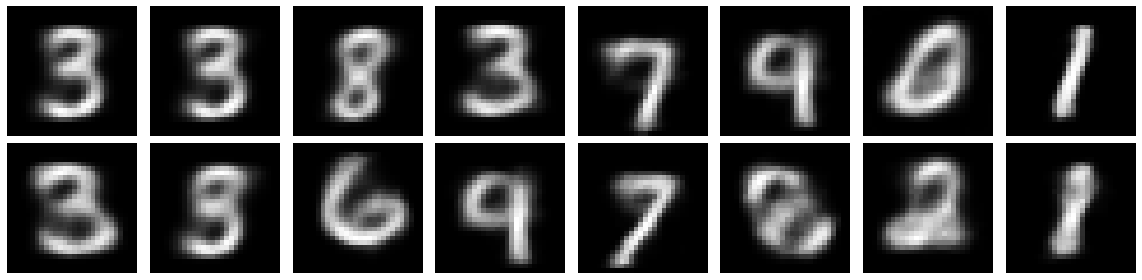

In [7]:

for epoch in range(1, 5):
    print('TRAIN EPOCH {} :'.format(epoch))
    train(epoch)
    test()
    

## Visualization
Latent space

In [0]:
# get latent space
z = np.zeros((len(train_dataset),2))
index_classe = [[],[],[],[],[],[],[],[],[],[]]
for i, (data, c) in enumerate(train_dataset):
    data    = data.cuda().view(-1, 784)
    z_i     = vae.get_latent_space(data)
    z[i,:] = z_i.cpu().data.numpy()
    index_classe[c].append(i)

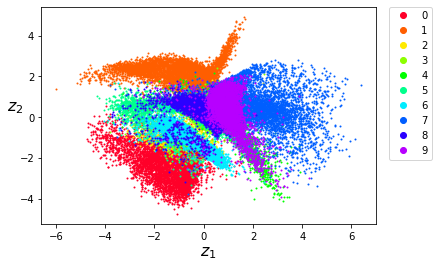

In [15]:
# plot and color according to classe
cm = plt.get_cmap('gist_rainbow')
for c in range(10):
    color = cm(c/10)
    plt.plot(z[index_classe[c],0], z[index_classe[c],1], 'o', c=color, markersize=1, label=c)

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=True, markerscale=6)
plt.xlabel('$z_1$', fontsize=16), plt.ylabel('$z_2$', fontsize=16, rotation=0)
plt.show()

A $10\times10$ mosaic by sampling *$z$* over a regulargrid in $[-1,1]\times[-1,1]$.



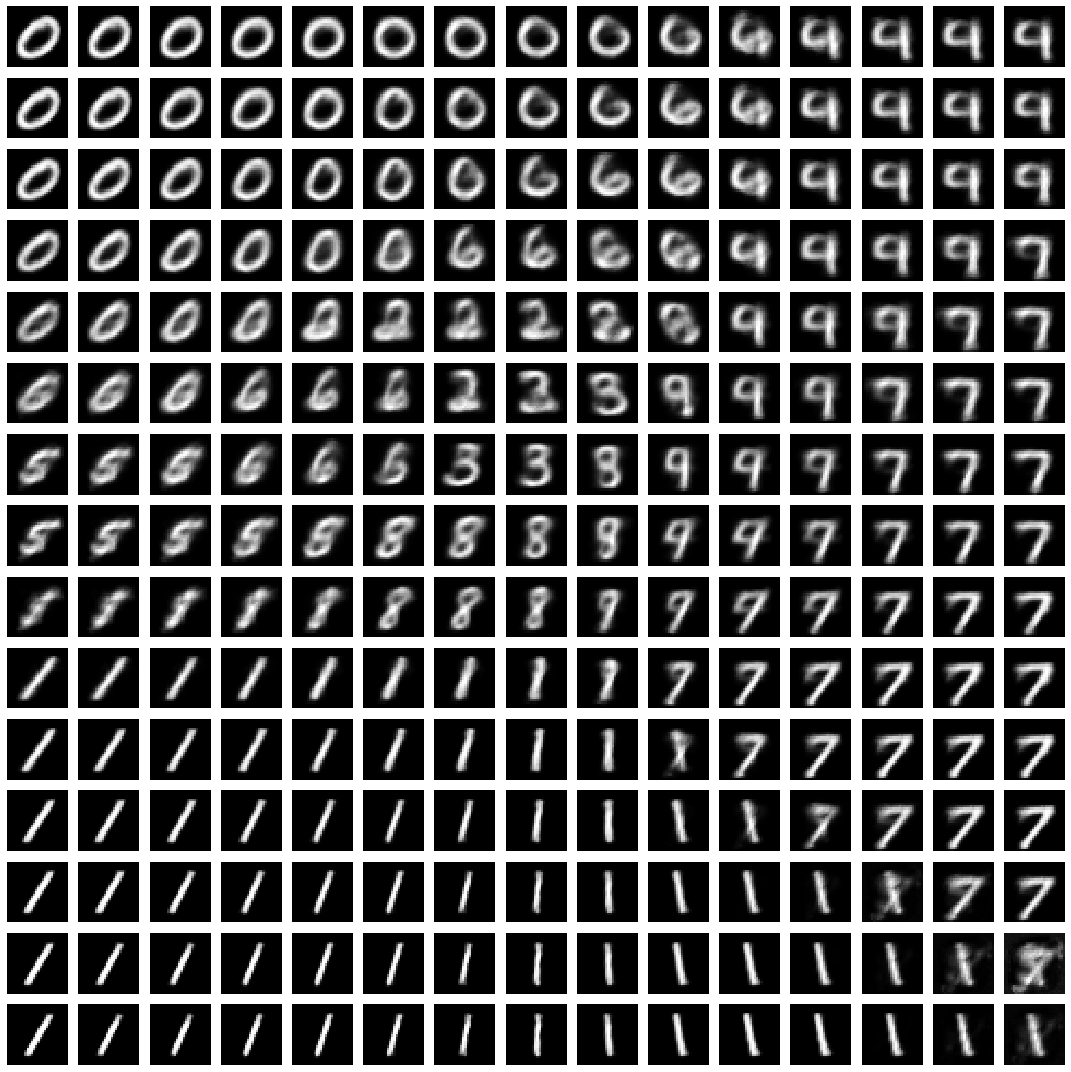

In [9]:
n = 15
x = np.linspace(-3, 3, n)
y = np.linspace(-3, 4, n)
z_interpolated = np.zeros((len(train_dataset),2))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(n,n))
for i,z_1 in enumerate(x):
  for j,z_2 in enumerate(y):
    z = np.array([z_1,z_2])
    z = torch.from_numpy(z).float().to(device)
    reconstructed = vae.decoder(z)
    image_reconstructed = reconstructed.view(28, 28).cpu().data.numpy()
    plt.subplot(n, n, j*n+i+1)
    plt.imshow(image_reconstructed, interpolation='nearest', cmap='gray')
    plt.axis('off')
  
plt.tight_layout()
plt.show()

## Interpolation
Sample two latent vectors and generate images by performing linear interpolation.

In [0]:
# ...


Sample real images from MNIST and flip them to obtain digits that do not exist. What do you observe about their likelihood?

In [0]:
# ...

## Fashion mnist
Change dataset. Replace mnist by fashionMNIST and check how it works.